In [1]:
!pip install -q kaggle

In [2]:
# kaggle.json ÌååÏùº ÏóÖÎ°úÎìú
from google.colab import files
files.upload()  # Ïó¨Í∏∞ÏÑú kaggle.json ÌååÏùº ÏóÖÎ°úÎìú!

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yjkimliz03","key":"71f14de2ef33e4126809eda8b6a7c7e2"}'}

In [3]:
# ÎîîÎ†âÌÜ†Î¶¨ Ïù¥Îèô Î∞è Í∂åÌïú ÏÑ§Ï†ï
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Îã§Ïö¥Î°úÎìú (melanoma Îç∞Ïù¥ÌÑ∞ÏÖã ÏòàÏãú)
!kaggle datasets download -d newyjkimliz03/isic-2020-resized

Dataset URL: https://www.kaggle.com/datasets/newyjkimliz03/isic-2020-resized
License(s): DbCL-1.0
 99% 224M/227M [00:11<00:00, 24.4MB/s]
100% 227M/227M [00:11<00:00, 21.5MB/s]


In [5]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Îã§Ïö¥Î°úÎìú (melanoma Îç∞Ïù¥ÌÑ∞ÏÖã ÏòàÏãú)
!kaggle datasets download -d newyjkimliz03/isic-2019-resized

Dataset URL: https://www.kaggle.com/datasets/newyjkimliz03/isic-2019-resized
License(s): DbCL-1.0
 98% 73.0M/74.6M [00:04<00:00, 21.4MB/s]
100% 74.6M/74.6M [00:04<00:00, 17.9MB/s]


In [6]:
!unzip isic-2020-resized.zip

Ïä§Ìä∏Î¶¨Î∞ç Ï∂úÎ†• ÎÇ¥Ïö©Ïù¥ Í∏∏Ïñ¥ÏÑú ÎßàÏßÄÎßâ 5000Ï§ÑÏù¥ ÏÇ≠Ï†úÎêòÏóàÏäµÎãàÎã§.
  inflating: isic-2020-resized/train-resized/ISIC_8512716.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8513112.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8513649.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8514170.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8514989.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515165.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515281.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515582.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8515674.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516181.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516223.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516516.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516631.jpg  
  inflating: isic-2020-resized/train-resized/ISIC_8516659.jpg  
  inflating: isic-20

In [7]:
!unzip isic-2019-resized.zip

Archive:  isic-2019-resized.zip
  inflating: isic-2019-resized/csv_filter.py  
  inflating: isic-2019-resized/images_filter.py  
  inflating: isic-2019-resized/train-labels.csv  
  inflating: isic-2019-resized/train-resized/ISIC_0000002.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000004.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000013.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000022_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000026_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000029_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000030_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000031_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000035_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000036_downsampled.jpg  
  inflating: isic-2019-resized/train-resized/ISIC_0000040_downsampled.jpg  
  inflating: isic-201

In [8]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime
import time
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

In [9]:
# D√©finit le dataset √† partir des fichiers fournis
class CustomDataset(Dataset):
    def __init__(self, data_folder, dataframe, transform=None):
        self.data_folder = data_folder
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.dataframe.iloc[idx, 0] + ".jpg")
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

def format_time(seconds):
    minutes, seconds = divmod(int(seconds), 60)
    hours, minutes = divmod(minutes, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [10]:
print(datetime.now())

# V√©rifie si un GPU est disponible, et d√©finit la variable device en cons√©quence
print("Running on GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# writer = SummaryWriter("logs3", comment="EfficientNet-b0")
writer = SummaryWriter("logs3", comment="ResNet50")

2025-03-08 12:26:09.832219
Running on GPU: True


In [11]:
# Liens des images et des labels
data_folder_2020 = "/content/isic-2020-resized/train-resized"
label_file_2020 = "/content/isic-2020-resized/train-labels.csv"

data_folder_2019 = "/content/isic-2019-resized/train-resized"
label_file_2019 = "/content/isic-2019-resized/train-labels.csv"

In [12]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
labels_2020 = pd.read_csv(label_file_2020)
labels_2019 = pd.read_csv(label_file_2019)

# 2020ÎÖÑ Îç∞Ïù¥ÌÑ∞: train (70%), validation (20%), test (10%)ÏúºÎ°ú ÎÇòÎàÑÍ∏∞
train_dataframe_2020, temp_dataframe_2020 = train_test_split(
    labels_2020, test_size=0.3, random_state=42, stratify=labels_2020['target'])

val_dataframe_2020, test_dataframe_2020 = train_test_split(
    temp_dataframe_2020, test_size=1/3, random_state=42, stratify=temp_dataframe_2020['target'])

# 2019ÎÖÑ Îç∞Ïù¥ÌÑ∞: train (70%), validation (20%), test (10%)ÏúºÎ°ú ÎÇòÎàÑÍ∏∞
train_dataframe_2019, temp_dataframe_2019 = train_test_split(
    labels_2019, test_size=0.3, random_state=42, stratify=labels_2019['target'])

val_dataframe_2019, test_dataframe_2019 = train_test_split(
    temp_dataframe_2019, test_size=1/3, random_state=42, stratify=temp_dataframe_2019['target'])

In [13]:
# ‚úÖ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ï†ÅÏö© (ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏóêÎßå Ï†ÅÏö©)
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ‚úÖ Í≤ÄÏ¶ù & ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Îäî Ï¶ùÍ∞ï ÏóÜÏù¥ Í∏∞Î≥∏ Î≥ÄÌôòÎßå Ï†ÅÏö©
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
# Train Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± (2020 + 2019)
train_dataset_2020 = CustomDataset(data_folder_2020, train_dataframe_2020, train_transform)
train_dataset_2019 = CustomDataset(data_folder_2019, train_dataframe_2019, train_transform)
train_dataset = ConcatDataset([train_dataset_2020, train_dataset_2019])

# Validation Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± (2020 + 2019)
val_dataset_2020 = CustomDataset(data_folder_2020, val_dataframe_2020, val_test_transform)
val_dataset_2019 = CustomDataset(data_folder_2019, val_dataframe_2019, val_test_transform)
val_dataset = ConcatDataset([val_dataset_2020, val_dataset_2019])

# Test Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± (2020 + 2019)
test_dataset_2020 = CustomDataset(data_folder_2020, test_dataframe_2020, val_test_transform)
test_dataset_2019 = CustomDataset(data_folder_2019, test_dataframe_2019, val_test_transform)
test_dataset = ConcatDataset([test_dataset_2020, test_dataset_2019])

In [15]:
# ‚úÖ WeightedRandomSampler Ï†ÅÏö© (ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î≥¥Ï†ï)
batch_size = 64

all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
class_counts = all_train_labels.value_counts()
# weights = 1.0 / class_counts
weights = sum(class_counts) / class_counts  # Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò / Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå Ïàò
sample_weights = all_train_labels.map(weights)
sampler = WeightedRandomSampler(torch.tensor(sample_weights.values, dtype=torch.float32), len(all_train_labels))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


## EfficientNet

In [16]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # EfficientNet
# lr = 0.001
# l2_reg = 0.0001
# num_epochs = 5

# # Î™®Îç∏ Ï¥àÍ∏∞Ìôî
# model = models.efficientnet_v2_m(weights='IMAGENET1K_V1')
# model.classifier[1] = nn.Linear(1280, 2)

# model = model.to(device)

# # ÏÜêÏã§ Ìï®Ïàò Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä
# # criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 13.0]).to(device))
# # criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights.values).to(device))
# criterion = nn.CrossEntropyLoss(
#     weight=torch.tensor(weights.values, dtype=torch.float32).to(device)
# )
# optimizer = AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)
# # scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

## ResNet

In [17]:
lr = 0.001
l2_reg = 0.0001
num_epochs = 20

# ‚úÖ ResNet50 Î™®Îç∏ Ï¥àÍ∏∞Ìôî
weights = models.ResNet50_Weights.IMAGENET1K_V1  # IMAGENET1K_V1 Ïõ®Ïù¥Ìä∏ ÏÇ¨Ïö©
model = models.resnet50(weights=weights)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2Í∞úÏùò ÌÅ¥ÎûòÏä§ (Benign, Melanoma)
model = model.to(device)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú ÏûêÎèôÏúºÎ°ú ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
class_counts = all_train_labels.value_counts()
weights = sum(class_counts) / class_counts  # Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò / Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå Ïàò

# ‚úÖ Í∞ÄÏ§ëÏπòÎ•º torch.TensorÎ°ú Î≥ÄÌôòÌïòÏó¨ ÏÜêÏã§ Ìï®ÏàòÏóê Ï†ÅÏö©
class_weights = torch.tensor(weights.to_numpy(), dtype=torch.float32).to(device)

# ‚úÖ ÏÜêÏã§ Ìï®Ïàò Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:00<00:00, 224MB/s]


## LeNet

In [18]:
# import torch
# from torch import nn
# import torch.nn.functional as F

# class LeNet_5(nn.Module):
#     def __init__(self):
#         super(LeNet_5, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)  # ‚úÖ RGB ÏûÖÎ†• (3Ï±ÑÎÑê)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
#         self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
#         self.fc1 = nn.Linear(120, 84)
#         self.fc2 = nn.Linear(84, 2)  # ‚úÖ 2Í∞úÏùò ÌÅ¥ÎûòÏä§ (Benign, Melanoma)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.avg_pool2d(x, 2, 2)
#         x = F.relu(self.conv2(x))
#         x = F.avg_pool2d(x, 2, 2)
#         x = F.relu(self.conv3(x))
#         x = x.view(x.size(0), -1)  # ‚úÖ (batch_size, 120) ÌòïÌÉúÎ°ú Î≥ÄÌôò
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)  # ‚úÖ CrossEntropyLossÎ•º ÏÇ¨Ïö©ÌïòÎØÄÎ°ú softmax Ï†úÍ±∞
#         return x

# # ‚úÖ Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌôïÏù∏
# model = LeNet_5().to(device)

In [19]:
# train_transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # ‚úÖ LeNet-5Ïóê ÎßûÍ≤å ÌÅ¨Í∏∞ Ï∂ïÏÜå
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# val_test_transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # ‚úÖ LeNet-5Ïóê ÎßûÍ≤å ÌÅ¨Í∏∞ Ï∂ïÏÜå
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [20]:
# lr = 0.001
# l2_reg = 0.0001
# num_epochs = 20

# # ‚úÖ ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò ÏûêÎèô Í≥ÑÏÇ∞
# all_train_labels = pd.concat([train_dataframe_2020, train_dataframe_2019])['target']
# class_counts = all_train_labels.value_counts()
# weights = sum(class_counts) / class_counts  # Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò / Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå Ïàò

# # ‚úÖ Í∞ÄÏ§ëÏπòÎ•º torch.TensorÎ°ú Î≥ÄÌôòÌïòÏó¨ ÏÜêÏã§ Ìï®ÏàòÏóê Ï†ÅÏö©
# class_weights = torch.tensor(weights.to_numpy(), dtype=torch.float32).to(device)

# # ‚úÖ ÏÜêÏã§ Ìï®Ïàò Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

## DataSet ÌôïÏù∏

In [21]:
# ‚úÖ ÌÉÄÍ≤ü(0Í≥º 1) Í∞úÏàò Î∞è 2020/2019 Îç∞Ïù¥ÌÑ∞ ÎπÑÏú® Ï∂úÎ†•
def count_targets_v2(df_2020, df_2019, name):
    total_2020 = len(df_2020)
    total_2019 = len(df_2019)
    total_all = total_2020 + total_2019  # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò

    target_counts_2020 = df_2020['target'].value_counts().to_dict()
    target_counts_2019 = df_2019['target'].value_counts().to_dict()

    print(f"\n {name} dataset:")
    print(f"   - Total: {total_all} images")
    print(f"   - 2020 Îç∞Ïù¥ÌÑ∞: {total_2020} images ({total_2020 / total_all * 100:.2f}%)")
    print(f"   - 2019 Îç∞Ïù¥ÌÑ∞: {total_2019} images ({total_2019 / total_all * 100:.2f}%)")
    print(f"   - Target 0 (Ï†ïÏÉÅ) - 2020: {target_counts_2020.get(0, 0)}, 2019: {target_counts_2019.get(0, 0)}, Total: {target_counts_2020.get(0, 0) + target_counts_2019.get(0, 0)}")
    print(f"   - Target 1 (Melanoma) - 2020: {target_counts_2020.get(1, 0)}, 2019: {target_counts_2019.get(1, 0)}, Total: {target_counts_2020.get(1, 0) + target_counts_2019.get(1, 0)}")
    print("-" * 50)

print("Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ ÏôÑÎ£å")

# üî• Train, Validation, Test Í∞ÅÍ∞Å 2020Í≥º 2019 Îç∞Ïù¥ÌÑ∞Î•º Ìï©Ï≥êÏÑú Ï∂úÎ†•
count_targets_v2(train_dataframe_2020, train_dataframe_2019, "Train")
count_targets_v2(val_dataframe_2020, val_dataframe_2019, "Validation")
count_targets_v2(test_dataframe_2020, test_dataframe_2019, "Test")

Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ ÏôÑÎ£å

 Train dataset:
   - Total: 26353 images
   - 2020 Îç∞Ïù¥ÌÑ∞: 23188 images (87.99%)
   - 2019 Îç∞Ïù¥ÌÑ∞: 3165 images (12.01%)
   - Target 0 (Ï†ïÏÉÅ) - 2020: 22779, 2019: 0, Total: 22779
   - Target 1 (Melanoma) - 2020: 409, 2019: 3165, Total: 3574
--------------------------------------------------

 Validation dataset:
   - Total: 7529 images
   - 2020 Îç∞Ïù¥ÌÑ∞: 6625 images (87.99%)
   - 2019 Îç∞Ïù¥ÌÑ∞: 904 images (12.01%)
   - Target 0 (Ï†ïÏÉÅ) - 2020: 6508, 2019: 0, Total: 6508
   - Target 1 (Melanoma) - 2020: 117, 2019: 904, Total: 1021
--------------------------------------------------

 Test dataset:
   - Total: 3766 images
   - 2020 Îç∞Ïù¥ÌÑ∞: 3313 images (87.97%)
   - 2019 Îç∞Ïù¥ÌÑ∞: 453 images (12.03%)
   - Target 0 (Ï†ïÏÉÅ) - 2020: 3255, 2019: 0, Total: 3255
   - Target 1 (Melanoma) - 2020: 58, 2019: 453, Total: 511
--------------------------------------------------


In [22]:
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# # ÏµúÏ†Å Î™®Îç∏ Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î≥ÄÏàò
# best_auc = 0.0

# train_losses, val_losses, train_aucs, val_aucs = [], [], [], []

# print("Starting")
# start_time = time.time()
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     all_labels = []
#     all_predictions = []
#     all_probs = []

#     # ÎûúÎç§ ÏÉòÌîåÎßÅÎêú DataLoader ÏÉùÏÑ±
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

#     # Train Loop
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         # ÏòàÏ∏°Í∞í Ï†ÄÏû•
#         _, predicted = torch.max(outputs, 1)
#         probs = torch.softmax(outputs, dim=1)[:, 1]  # Melanoma ÌôïÎ•†

#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())
#         all_probs.extend(probs.detach().cpu().numpy())  # ‚úÖ detach() Ï∂îÍ∞Ä

#     train_losses.append(total_loss / len(train_loader))
#     train_auc = roc_auc_score(all_labels, all_probs)  # ‚úÖ Train AUC Í≥ÑÏÇ∞
#     train_aucs.append(train_auc)  # ‚úÖ Ï†ÄÏû•

#     # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
#     accuracy = accuracy_score(all_labels, all_predictions) * 100
#     auc = roc_auc_score(all_labels, all_probs)
#     precision = precision_score(all_labels, all_predictions, zero_division=0)
#     recall = recall_score(all_labels, all_predictions, zero_division=0)
#     f1 = f1_score(all_labels, all_predictions, zero_division=0)

#     print(f"Training - Epoch {epoch + 1}: Loss={total_loss/len(train_loader):.4f}, "
#           f"Acc={accuracy:.2f}%, AUC={auc:.4f}, Precision={precision:.4f}, "
#           f"Recall={recall:.4f}, F1={f1:.4f}, LR={optimizer.param_groups[0]['lr']}")

#     # TensorBoard Í∏∞Î°ù
#     writer.add_scalar("Training/Loss", total_loss/len(train_loader), epoch)
#     writer.add_scalar("Training/Accuracy", accuracy, epoch)
#     writer.add_scalar("Training/AUC", auc, epoch)
#     writer.add_scalar("Training/Precision", precision, epoch)
#     writer.add_scalar("Training/Recall", recall, epoch)
#     writer.add_scalar("Training/F1", f1, epoch)
#     writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

#     torch.save(model.state_dict(), f'EfficientNet-{epoch + 1}-l2reg0.001.pth')

#     # Validation Loop
#     model.eval()
#     total_val_loss = 0.0
#     val_labels = []
#     val_predictions = []
#     val_probs = []

#     val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             val_outputs = model(inputs)
#             val_loss = criterion(val_outputs, labels)
#             total_val_loss += val_loss.item()

#             # ÏòàÏ∏°Í∞í Ï†ÄÏû•
#             _, predicted = torch.max(val_outputs, 1)
#             probs = torch.softmax(val_outputs, dim=1)[:, 1]  # Melanoma ÌôïÎ•†

#             val_labels.extend(labels.cpu().numpy())
#             val_predictions.extend(predicted.cpu().numpy())
#             val_probs.extend(probs.detach().cpu().numpy())  # ‚úÖ detach() Ï∂îÍ∞Ä

#     # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
#     val_accuracy = accuracy_score(val_labels, val_predictions) * 100
#     val_auc = roc_auc_score(val_labels, val_probs)
#     val_precision = precision_score(val_labels, val_predictions, zero_division=0)
#     val_recall = recall_score(val_labels, val_predictions, zero_division=0)
#     val_f1 = f1_score(val_labels, val_predictions, zero_division=0)

#     # Validation Loss Ï†ÄÏû•
#     val_losses.append(total_val_loss / len(val_loader))
#     val_aucs.append(val_auc)  # ‚úÖ Ï†ÄÏû•

#     # üî• **Validation Loss Í∏∞Ï§ÄÏúºÎ°ú LR Í∞êÏÜå** üî•
#     scheduler.step(total_val_loss / len(val_loader))  # ‚úÖ Ï∂îÍ∞Ä

#     if val_auc > best_auc:
#         best_auc = val_auc
#         torch.save(model.state_dict(), 'best_model.pth')

#     print(f"Validation - Epoch {epoch + 1}: Loss={total_val_loss/len(val_loader):.4f}, "
#           f"Acc={val_accuracy:.2f}%, AUC={val_auc:.4f}, Precision={val_precision:.4f}, "
#           f"Recall={val_recall:.4f}, F1={val_f1:.4f}, LR={optimizer.param_groups[0]['lr']}")  # ‚úÖ LR Ï∂îÍ∞Ä Ï∂úÎ†•

#     # TensorBoard Í∏∞Î°ù
#     writer.add_scalar("Validation/Loss", total_val_loss/len(val_loader), epoch)
#     writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)
#     writer.add_scalar("Validation/AUC", val_auc, epoch)
#     writer.add_scalar("Validation/Precision", val_precision, epoch)
#     writer.add_scalar("Validation/Recall", val_recall, epoch)
#     writer.add_scalar("Validation/F1", val_f1, epoch)

# print("Training completed!")
# writer.close()

In [23]:
# Ïò§Î¶¨ÏßÄÎÑê

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# ÏµúÏ†Å Î™®Îç∏ Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î≥ÄÏàò
best_auc = 0.0
best_val_loss = float('inf')  # ‚úÖ Ï¥àÍ∏∞Í∞íÏùÑ Î¨¥ÌïúÎåÄÎ°ú ÏÑ§Ï†ï


train_losses, val_losses, train_aucs, val_aucs = [], [], [], []

print("Starting")
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    # ÎûúÎç§ ÏÉòÌîåÎßÅÎêú DataLoader ÏÉùÏÑ±
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)


    # Train Loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # inputs = inputs.to(torch.float32)

        # inputs, labels = inputs.to(device), labels.to(device).long()  # labelsÎ•º long()ÏúºÎ°ú Î≥ÄÌôò
        optimizer.zero_grad()
        outputs = model(inputs)
        # outputs = model(inputs).float()  # outputsÏùÑ float32Î°ú Î≥ÄÌôò
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # ÏòàÏ∏°Í∞í Ï†ÄÏû•
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Melanoma ÌôïÎ•†

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())  # ‚úÖ detach() Ï∂îÍ∞Ä

    train_losses.append(total_loss / len(train_loader))
    train_auc = roc_auc_score(all_labels, all_probs)  # ‚úÖ Train AUC Í≥ÑÏÇ∞
    train_aucs.append(train_auc)  # ‚úÖ Ï†ÄÏû•

    # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    auc = roc_auc_score(all_labels, all_probs)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    print(f"Training - Epoch {epoch + 1}: Loss={total_loss/len(train_loader):.4f}, "
          f"Acc={accuracy:.2f}%, AUC={auc:.4f}, Precision={precision:.4f}, "
          f"Recall={recall:.4f}, F1={f1:.4f}, LR={optimizer.param_groups[0]['lr']}")

    # TensorBoard Í∏∞Î°ù
    writer.add_scalar("Training/Loss", total_loss/len(train_loader), epoch)
    writer.add_scalar("Training/Accuracy", accuracy, epoch)
    writer.add_scalar("Training/AUC", auc, epoch)
    writer.add_scalar("Training/Precision", precision, epoch)
    writer.add_scalar("Training/Recall", recall, epoch)
    writer.add_scalar("Training/F1", f1, epoch)
    writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

    torch.save(model.state_dict(), f'EfficientNet-{epoch + 1}-l2reg0.001.pth')
    # scheduler.step()

    # Boucle de validation
    model.eval()
    total_val_loss = 0.0
    val_labels = []
    val_predictions = []
    val_probs = []

    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    # Validation Loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()

            # ÏòàÏ∏°Í∞í Ï†ÄÏû•
            _, predicted = torch.max(val_outputs, 1)
            probs = torch.softmax(val_outputs, dim=1)[:, 1]  # Melanoma ÌôïÎ•†

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())
            val_probs.extend(probs.detach().cpu().numpy())  # ‚úÖ detach() Ï∂îÍ∞Ä

    # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
    val_accuracy = accuracy_score(val_labels, val_predictions) * 100
    val_auc = roc_auc_score(val_labels, val_probs)
    val_precision = precision_score(val_labels, val_predictions, zero_division=0)
    val_recall = recall_score(val_labels, val_predictions, zero_division=0)
    val_f1 = f1_score(val_labels, val_predictions, zero_division=0)
    #val loss, auc Ï†ÄÏû•
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)  # ‚úÖ Ï†ÄÏû•

    # if val_auc > best_auc:
    #     best_auc = val_auc
    #     torch.save(model.state_dict(), 'best_model.pth')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Validation - Epoch {epoch + 1}: Loss={total_val_loss/len(val_loader):.4f}, "
          f"Acc={val_accuracy:.2f}%, AUC={val_auc:.4f}, Precision={val_precision:.4f}, "
          f"Recall={val_recall:.4f}, F1={val_f1:.4f}")

    # TensorBoard Í∏∞Î°ù
    writer.add_scalar("Validation/Loss", total_val_loss/len(val_loader), epoch)
    writer.add_scalar("Validation/Accuracy", val_accuracy, epoch)
    writer.add_scalar("Validation/AUC", val_auc, epoch)
    writer.add_scalar("Validation/Precision", val_precision, epoch)
    writer.add_scalar("Validation/Recall", val_recall, epoch)
    writer.add_scalar("Validation/F1", val_f1, epoch)

print("Training completed!")
writer.close()

Starting
Training - Epoch 1: Loss=0.1312, Acc=86.40%, AUC=0.9766, Precision=0.8048, Recall=0.9636, F1=0.8770, LR=0.001
Validation - Epoch 1: Loss=0.4584, Acc=74.10%, AUC=0.9814, Precision=0.3414, Recall=0.9794, F1=0.5063
Training - Epoch 2: Loss=0.1180, Acc=87.53%, AUC=0.9808, Precision=0.8186, Recall=0.9664, F1=0.8864, LR=0.001
Validation - Epoch 2: Loss=0.5009, Acc=73.60%, AUC=0.9816, Precision=0.3376, Recall=0.9843, F1=0.5028
Training - Epoch 3: Loss=0.1060, Acc=89.03%, AUC=0.9848, Precision=0.8335, Recall=0.9739, F1=0.8983, LR=0.001
Validation - Epoch 3: Loss=0.3158, Acc=89.08%, AUC=0.9814, Precision=0.5575, Recall=0.9442, F1=0.7011
Training - Epoch 4: Loss=0.0998, Acc=90.02%, AUC=0.9870, Precision=0.8485, Recall=0.9741, F1=0.9070, LR=0.001
Validation - Epoch 4: Loss=0.2702, Acc=92.28%, AUC=0.9816, Precision=0.6501, Recall=0.9334, F1=0.7664
Training - Epoch 5: Loss=0.0884, Acc=91.51%, AUC=0.9898, Precision=0.8693, Recall=0.9774, F1=0.9202, LR=0.001
Validation - Epoch 5: Loss=0.3079

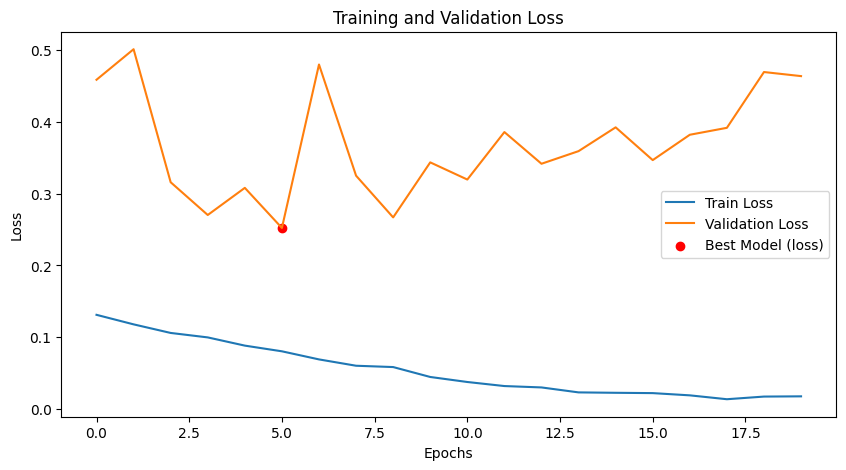

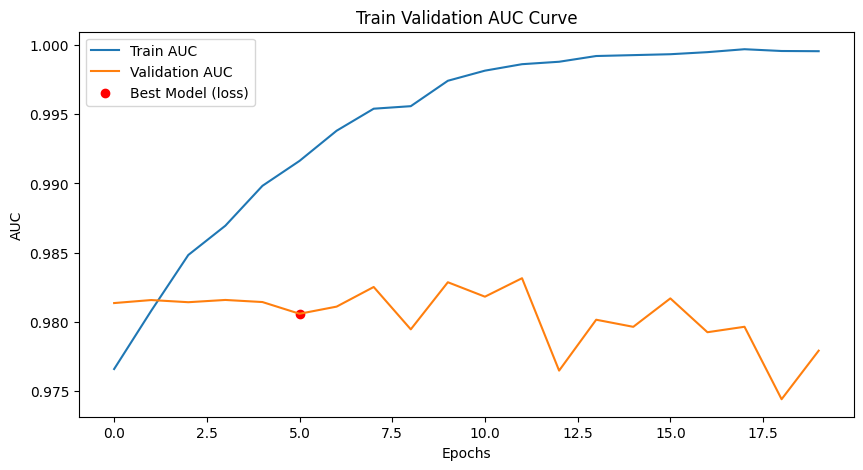

In [24]:
import matplotlib.pyplot as plt

# üî• ÏµúÏ†Å Loss Î™®Îç∏Ïù¥ Ï†ÄÏû•Îêú Epoch Ï∞æÍ∏∞
# best_epoch = val_aucs.index(best_auc)
best_epoch = val_losses.index(best_val_loss)


# ‚úÖ Training & Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.scatter(best_epoch, val_losses[best_epoch], color='red', marker='o', label='Best Model (loss)')  # üî¥ Ï∂îÍ∞Ä
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ‚úÖ Train & Validation AUC Curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_aucs, label='Train AUC')
plt.plot(range(num_epochs), val_aucs, label='Validation AUC')
plt.scatter(best_epoch, val_aucs[best_epoch], color='red', marker='o', label='Best Model (loss)')  # üî¥ Ï∂îÍ∞Ä
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Train Validation AUC Curve')
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# üî• Ï†ÄÏû•Îêú ÏµúÏ†Å Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
model.load_state_dict(torch.load('best_model.pth'))  # ‚úÖ best_model.pth Î∂àÎü¨Ïò§Í∏∞
model = model.to(device)
model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Î≥ÄÍ≤Ω

total_test_loss = 0.0
correct_test = 0
correct_test_class0 = 0
correct_test_class1 = 0
total_test = 0
total_test_class0 = 0
total_test_class1 = 0

all_test_labels = []
all_test_predictions = []
all_test_probs = []

print("\n[Start Test Evaluation]")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        test_outputs = model(inputs)
        test_loss = criterion(test_outputs, labels)
        total_test_loss += test_loss.item()

        # ÏòàÏ∏°Í∞í Ï†ÄÏû•
        _, predicted = torch.max(test_outputs, 1)
        probs = torch.softmax(test_outputs, dim=1)[:, 1]  # Melanoma ÌôïÎ•†

        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

        for i in range(len(predicted)):
            if labels[i] == 0:
                total_test_class0 += 1
                correct_test_class0 += (predicted[i] == labels[i]).item()
            elif labels[i] == 1:
                total_test_class1 += 1
                correct_test_class1 += (predicted[i] == labels[i]).item()

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
test_accuracy = accuracy_score(all_test_labels, all_test_predictions) * 100
test_auc = roc_auc_score(all_test_labels, all_test_probs)
test_precision = precision_score(all_test_labels, all_test_predictions, zero_division=0)
test_recall = recall_score(all_test_labels, all_test_predictions, zero_division=0)
test_f1 = f1_score(all_test_labels, all_test_predictions, zero_division=0)

test_accuracy_class0 = correct_test_class0 / total_test_class0 * 100
test_accuracy_class1 = correct_test_class1 / total_test_class1 * 100

# ÏµúÏ¢Ö Test Í≤∞Í≥º Ï∂úÎ†•
print(f"\n[Test Results]")
print(f"Loss: {total_test_loss/len(test_loader):.4f}")
print(f"Accuracy: {test_accuracy:.2f}% (Class 0: {test_accuracy_class0:.2f}%, Class 1: {test_accuracy_class1:.2f}%)")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


[Start Test Evaluation]


<ipython-input-25-75d328704458>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # ‚úÖ best_model.pth Î∂àÎü¨Ïò§Í∏∞



[Test Results]
Loss: 0.2345
Accuracy: 94.32% (Class 0: 94.81%, Class 1: 91.19%)
AUC: 0.9815
Precision: 0.7339
Recall: 0.9119
F1 Score: 0.8133



[Test Results]
Loss: 0.2345
Accuracy: 94.32% (Class 0: 94.81%, Class 1: 91.19%)
AUC: 0.9815
Precision: 0.7339
Recall: 0.9119
F1 Score: 0.8133


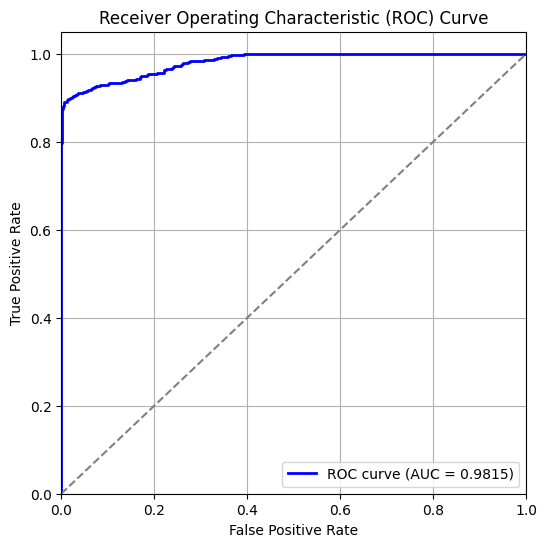

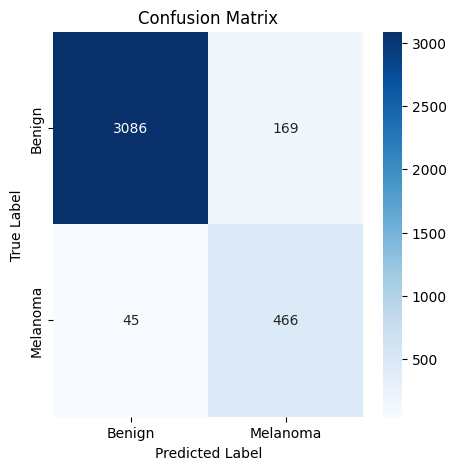

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1Ô∏è‚É£ Test Í≤∞Í≥º Ï∂úÎ†•
print(f"\n[Test Results]")
print(f"Loss: {total_test_loss/len(test_loader):.4f}")
print(f"Accuracy: {test_accuracy:.2f}% (Class 0: {test_accuracy_class0:.2f}%, Class 1: {test_accuracy_class1:.2f}%)")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# 2Ô∏è‚É£ ROC Curve ÏãúÍ∞ÅÌôî
fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # ÎåÄÍ∞ÅÏÑ† (ÎûúÎç§ ÏòàÏ∏°)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 3Ô∏è‚É£ Confusion Matrix ÏãúÍ∞ÅÌôî
cm = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Melanoma"], yticklabels=["Benign", "Melanoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()